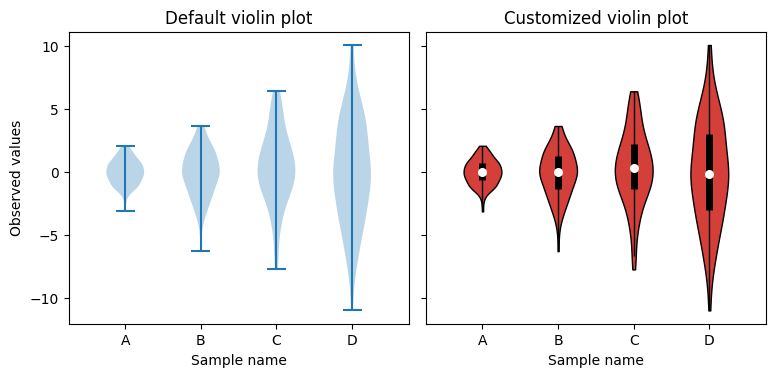

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')


# create test data
np.random.seed(19680801)
data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.set_title('Default violin plot')
ax1.set_ylabel('Observed values')
ax1.violinplot(data)

ax2.set_title('Customized violin plot')
parts = ax2.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['A', 'B', 'C', 'D']
for ax in [ax1, ax2]:
    set_axis_style(ax, labels)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

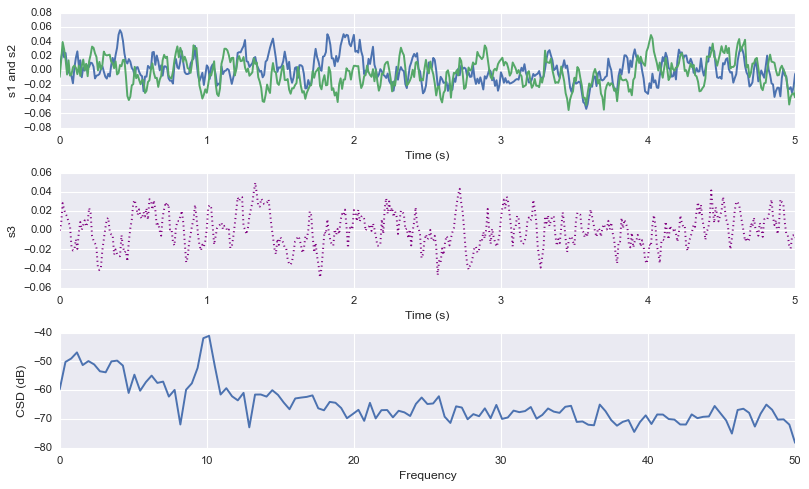

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.style.use('seaborn-v0_8')


fig, ax = plt.subplots(3, 1, layout='constrained', figsize=(10,6))

dt = 0.01
t = np.arange(0, 30, dt)

# Fixing random state for reproducibility
np.random.seed(19680801)


nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2
nse3 = np.random.randn(len(t))                 # white noise 2
r = np.exp(-t / 0.05)

cnse1 = np.convolve(nse1, r, mode='same') * dt   # colored noise 1
cnse2 = np.convolve(nse2, r, mode='same') * dt   # colored noise 2
cnse3 = np.convolve(nse3, r, mode='same') * dt   # colored noise 2

# two signals with a coherent part and a random part
s1 = 0.01 * np.sin(2 * np.pi * 10 * t) + cnse1
s2 = 0.01 * np.sin(2 * np.pi * 10 * t) + cnse2
s3 = 0.01 * np.sin(2 * np.pi * 10 * t) + cnse3

ax[0].plot(t, s1, t, s2)
ax[0].set_xlim(0, 5)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('s1 and s2')
ax[0].grid(True)

ax[1].plot(t, s3, color='purple', linestyle='dotted')
ax[1].set_xlim(0, 5)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('s3')
ax[1].grid(True)

cxy, f = ax[2].csd(s1, s2, NFFT=256, Fs=1. / dt)
ax[2].set_ylabel('CSD (dB)')

plt.show()

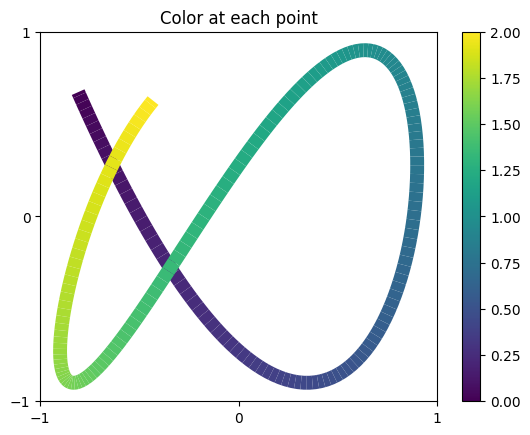

In [6]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


# -------------- Create and show plot --------------
# Some arbitrary function that gives x, y, and color values
t = np.linspace(-7.4, -0.5, 200)
x = 0.9 * np.sin(t)
y = 0.9 * np.cos(1.6 * t)
color = np.linspace(0, 2, t.size)

# Create a figure and plot the line on it
fig1, ax1 = plt.subplots()
lines = colored_line(x, y, color, ax1, linewidth=10, cmap="viridis")
fig1.colorbar(lines)  # add a color legend

# Set the axis limits and tick positions
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_xticks((-1, 0, 1))
ax1.set_yticks((-1, 0, 1))
ax1.set_title("Color at each point")

plt.show()

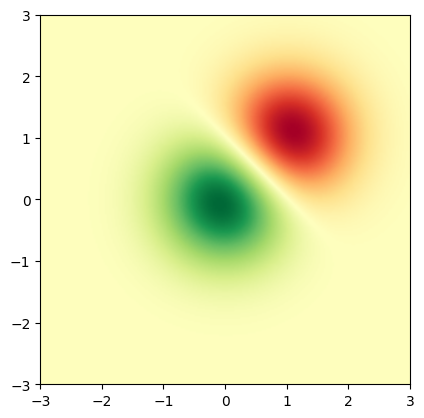

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cbook as cbook
import matplotlib.cm as cm
from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Fixing random state for reproducibility
np.random.seed(19680801)

delta = 0.025
x = y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=abs(Z).max(), vmin=-abs(Z).max())

plt.show()

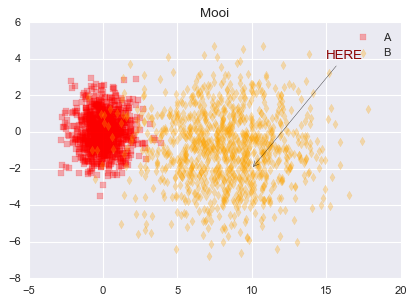

In [75]:
fig, ax = plt.subplots(figsize=(6, 4))

x = np.random.randn(1000)
y = np.random.randn(1000)

x2 = np.random.randn(1000) * 3 + 8
y2 = np.random.randn(1000) * 2 - 1

ax.set_title('Mooi')

# ax.hist(x, bins=np.arange(-4, 4.1, 0.5), histtype='step')

# plt.title('Minder')
# plt.hist(x)

ax.grid(zorder=-1)

ax.scatter(x, y, color='red', alpha=0.3, marker='s', s=30, label='A')
ax.scatter(x2, y2, color='orange', alpha=0.3, marker='d', s=30, label='B')

ax.annotate('HERE', xy=(10, -2), xytext=(15, 4), color='darkred', arrowprops={'arrowstyle':'->'})

ax.legend()

plt.show()

Text(0.5, 1.0, 'Simplest default with labels')

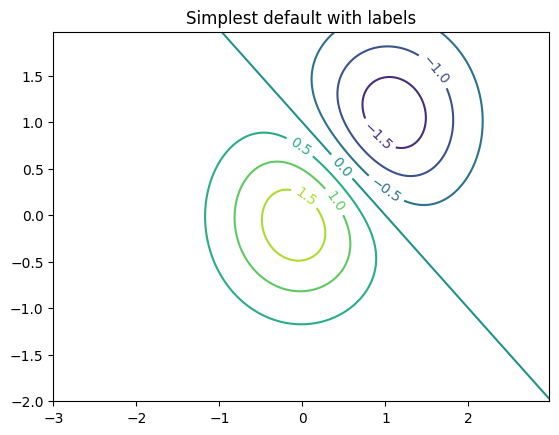

In [54]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, fontsize=10)
ax.set_title('Simplest default with labels')